# Importing the libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report)
# Step 1: Load & Clean the data
df = pd.read_csv("GOOG.csv")


# Data Preprocessing

In [4]:
# Convert TimeStamp to datetime
df['Date'] = pd.to_datetime(df['TimeStamp'], format='%Y%m%d')
df.rename(columns={'PeriodVolume': 'Volume'}, inplace=True)

In [5]:
# Drop unnecessary columns
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

In [6]:
#  Create Target Variable
def classify_trend(row):
    change = (row['Close'] - row['Open']) / row['Open'] * 100
    if change > 0.5:
        return 'Up'
    elif change < -0.5:
        return 'Down'
    else:
        return 'Neutral'

df['Trend'] = df.apply(classify_trend, axis=1)
print(df['Trend'])


0       Neutral
1          Down
2       Neutral
3            Up
4            Up
         ...   
2719         Up
2720       Down
2721       Down
2722       Down
2723         Up
Name: Trend, Length: 2724, dtype: object


# Feature Engineering

In [7]:
# Feature Engineering
# 10-day SMA of Close   #Simple Moving Average
df['SMA_10'] = df['Close'].rolling(window=10).mean()

In [8]:
# 14-day Stochastic Oscillator
low_14 = df['Low'].rolling(window=14).min()
high_14 = df['High'].rolling(window=14).max()
df['Stochastic_K'] = ((df['Close'] - low_14) / (high_14 - low_14)) * 100

In [9]:
# Volume change (%)
df['Volume_Change'] = df['Volume'].pct_change() * 100

In [10]:
# ATR (5-day)   #Average True Range
prev_close = df['Close'].shift(1)
tr1 = df['High'] - df['Low']
tr2 = (df['High'] - prev_close).abs()
tr3 = (df['Low'] - prev_close).abs()
tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
df['ATR_5'] = tr.rolling(window=5).mean()

In [11]:
# Drop NaN rows due to rolling calculations
df.dropna(inplace=True)

# Visualisation Of closing price and simple moving average

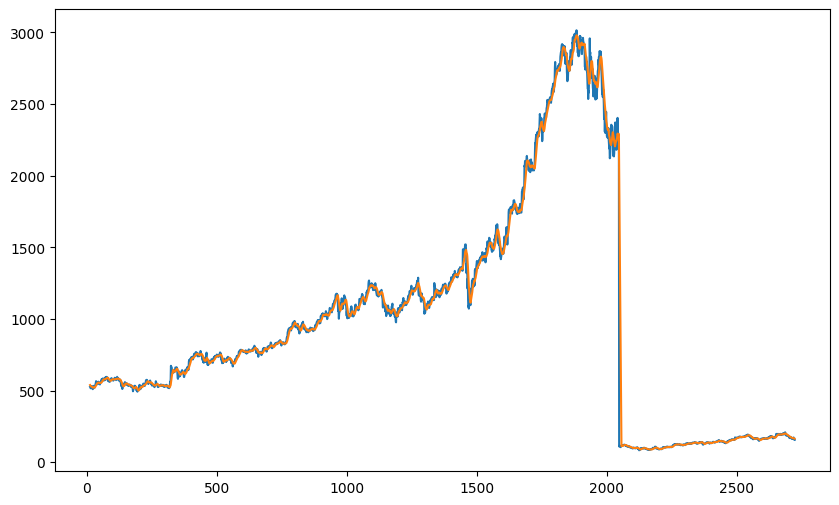

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(df.Close)
plt.plot(df.SMA_10)


In [13]:
# Model Development
# Features and Target
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'Stochastic_K', 'Volume_Change', 'ATR_5']
X = df[features]
y = df['Trend']

In [14]:
# Encode labels
y_encoded = y.astype('category').cat.codes
label_mapping = dict(enumerate(y.astype('category').cat.categories))

In [15]:
print("Label Mapping (encoded → original):")
for k, v in label_mapping.items():
    print(f"{k} → {v}")


Label Mapping (encoded → original):
0 → Down
1 → Neutral
2 → Up


In [33]:
# save the lanel prediction model
import joblib
joblib.dump(label_mapping, 'label_mapping.pkl')


['label_mapping.pkl']

In [16]:
df.head()

,Date,Open,High,Low,Close,Volume,Trend,SMA_10,Stochastic_K,Volume_Change,ATR_5
13,2014-04-23,533.79,533.87,526.25,526.94,41133985,Down,538.766,12.321999,-13.069085,15.066
14,2014-04-24,530.07,531.65,522.12,525.16,37742679,Down,534.868,11.296577,-8.244536,12.860
15,2014-04-25,522.51,524.70,515.42,516.18,42060482,Down,532.391,1.521522,11.440107,9.730
16,2014-04-28,517.18,518.60,502.80,517.15,66711295,Neutral,531.046,22.934314,58.608014,10.670
17,2014-04-29,516.90,529.46,516.32,527.70,53997686,Up,530.564,39.795429,-19.057656,11.354


In [17]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [18]:
# Train model
model = XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [19]:
# Predict
y_pred = model.predict(X_test)
print(y_pred)


[1 2 0 1 0 0 0 1 1 0 2 0 1 2 1 2 0 1 0 1 2 1 1 2 2 1 2 0 1 2 2 1 1 1 1 0 1
 2 2 1 1 1 0 0 1 1 0 1 1 0 2 0 2 1 1 0 1 1 2 2 2 1 2 0 2 0 2 0 2 0 2 1 1 1
 0 0 0 1 0 1 1 1 0 0 1 2 2 1 0 0 1 0 1 2 2 2 1 0 2 0 2 0 0 1 1 2 1 0 1 1 0
 1 0 1 2 2 1 1 0 0 2 1 0 2 2 1 1 1 0 1 2 1 1 1 2 1 1 2 1 0 0 1 0 0 0 2 1 0
 2 2 0 1 1 2 2 0 2 0 0 2 2 2 2 0 0 0 1 1 1 2 1 0 0 1 2 2 1 1 2 1 0 2 0 2 2
 1 1 1 1 1 1 0 0 1 1 2 1 0 0 2 2 0 1 0 1 2 2 0 2 0 2 1 2 1 2 1 1 1 2 0 2 1
 2 0 2 1 0 2 2 2 1 1 1 2 1 0 0 1 2 0 1 1 0 0 0 2 2 1 2 0 2 1 2 0 0 0 0 0 2
 0 1 0 2 2 1 1 1 2 1 2 1 1 0 2 2 2 0 1 0 1 1 2 2 1 1 1 0 1 0 2 0 2 2 2 0 0
 0 1 1 0 1 0 2 0 1 2 0 1 0 0 1 2 0 1 1 1 1 2 2 1 0 2 1 0 0 0 2 1 0 1 2 0 2
 1 2 2 0 1 2 0 1 0 2 0 2 2 2 2 1 2 1 0 0 1 1 2 0 1 1 2 0 1 2 0 2 2 0 1 2 0
 1 2 2 1 2 2 2 0 0 1 2 0 2 0 1 0 0 0 1 1 0 2 1 0 1 2 0 2 2 2 2 0 1 2 0 1 2
 2 2 1 2 2 2 1 0 1 0 0 0 1 2 0 0 1 2 0 2 1 0 0 1 0 0 1 0 1 0 2 0 2 2 1 0 1
 2 2 1 1 2 1 2 1 1 1 0 2 1 0 2 1 1 2 2 2 1 0 0 0 0 2 0 1 1 1 1 2 1 2 2 1 1
 0 1 2 0 0 2 1 2 0 0 1 1 

In [32]:
y_pred = model.predict(X_test)

predicted_class = int(y_pred[0])  # extract number
trend = label_mapping[predicted_class]

print("Predicted Trend:", trend)


Predicted Trend: Neutral


# Model Evaluation

In [20]:
#  Evaluation

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred, target_names=label_mapping.values())
print(accuracy)


0.5893186003683242


In [21]:
# Print metrics
print("Model Evaluation Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}\n")
print("Classification Report:\n", report)

Model Evaluation Metrics:
Accuracy : 0.5893
Precision: 0.5900
Recall   : 0.5893
F1 Score : 0.5894

Classification Report:
               precision    recall  f1-score   support

        Down       0.58      0.61      0.59       160
     Neutral       0.57      0.57      0.57       195
          Up       0.62      0.59      0.60       188

    accuracy                           0.59       543
   macro avg       0.59      0.59      0.59       543
weighted avg       0.59      0.59      0.59       543



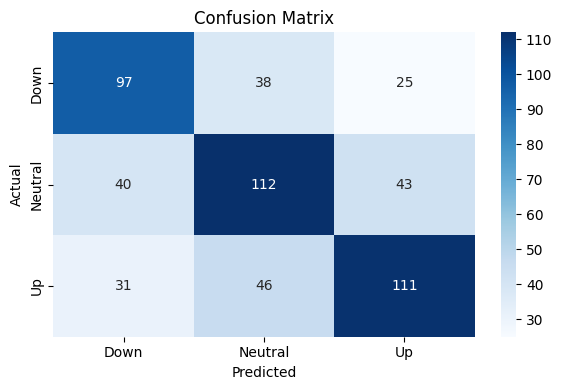

In [22]:
# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_mapping.values(),
            yticklabels=label_mapping.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

In [23]:
# Feature Importances
importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(importance_df.to_string(index=False))


Feature Importances:
      Feature  Importance
 Stochastic_K    0.154003
          Low    0.133652
        Close    0.127957
         High    0.106266
        ATR_5    0.103814
         Open    0.099153
Volume_Change    0.093802
       SMA_10    0.093693
       Volume    0.087660


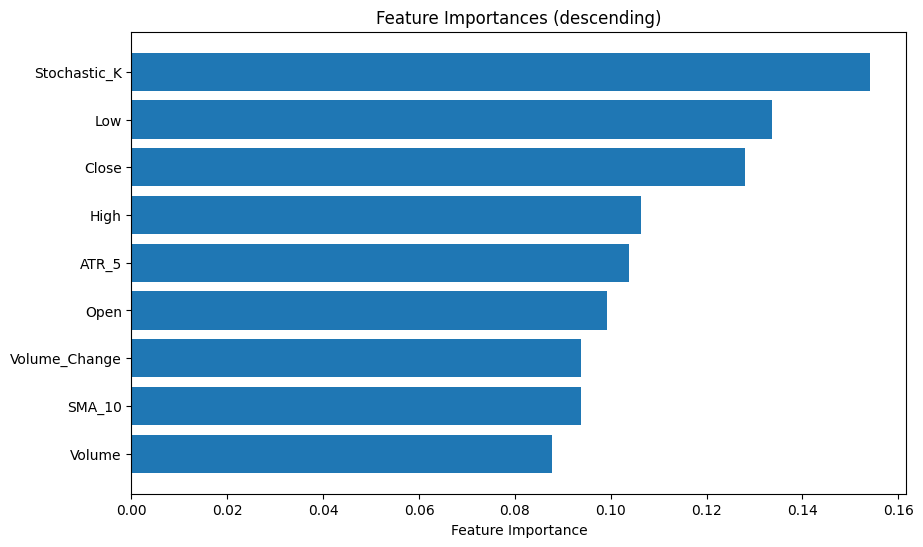

In [24]:

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.barh([features[i] for i in indices], importances[indices])
plt.xlabel("Feature Importance")
plt.title("Feature Importances (descending)")
plt.gca().invert_yaxis()  # so highest importance is on top
plt.show()


In [25]:
from joblib import dump, load 
dump(model, 'my_saved_model.joblib')
print("Model saved to file 'my_saved_model.joblib'")

Model saved to file 'my_saved_model.joblib'


# Model prediction

In [26]:
import pandas as pd
import numpy as np

def predict_with_dict(model, input_dict):
    # Define feature names exactly as used in training
    feature_names = [
        'Stochastic_K',
        'Low',
        'Close',
        'High',
        'ATR_5',
        'Open',
        'Volume_Change',
        'SMA_10',
        'Volume'
    ]

    # Check input dict has all needed keys
    missing = [f for f in feature_names if f not in input_dict]
    extra = [k for k in input_dict.keys() if k not in feature_names]
    if missing:
        raise ValueError(f"Missing features: {missing}")
    if extra:
        print("Warning: extra features will be ignored:", extra)

    # Build DataFrame with correct column order
    df = pd.DataFrame([{f: input_dict[f] for f in feature_names}], columns=feature_names)

   
    # Predict
    y_pred = model.predict(X)
    return y_pred[0]

    

In [35]:
from joblib import load

model = load('my_saved_model.joblib')     

input_data = {
    'Stochastic_K': 0.65,
    'Low': 298.0,
    'Close': 302.5,
    'High': 305.0,
    'ATR_5': 2.15,
    'Open': 300.8,
    'Volume_Change': 0.05,
    'SMA_10': 299.8,
    'Volume': 1500000
}

prediction = predict_with_dict(model, input_data)
print("Predicted class / trend:", prediction)

# Extract integer
pred_class = int(prediction)

# Decode to label
predicted_label = label_mapping[pred_class]

print("Predicted Trend:", predicted_label)


Predicted class / trend: 0
Predicted Trend: Down
